In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train_filepath='../input/titanic/train.csv'
test_filepath='../input/titanic/test.csv'
titanic_data=pd.read_csv(train_filepath)
test_data=pd.read_csv(test_filepath)
df=titanic_data.copy()

# EDA

# Analyse basique

# Analyse de la forme

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.shape

(891, 12)

In [5]:
#pour les pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

In [6]:
#pour les countplot
def countplot_with_percent(x,hue):
    df1 = df.groupby(x)[hue].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.catplot(x=x,y='percent',hue=hue,kind='bar',data=df1)
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

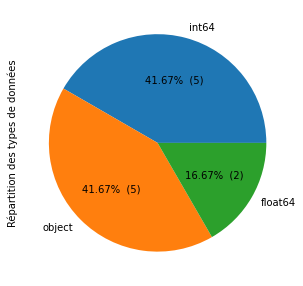

In [7]:
plt.figure(figsize=(5,5))
df.dtypes.value_counts().plot.pie(label='Répartition des types de données',
                                  autopct=make_autopct(df.dtypes.value_counts()))

In [8]:
df.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

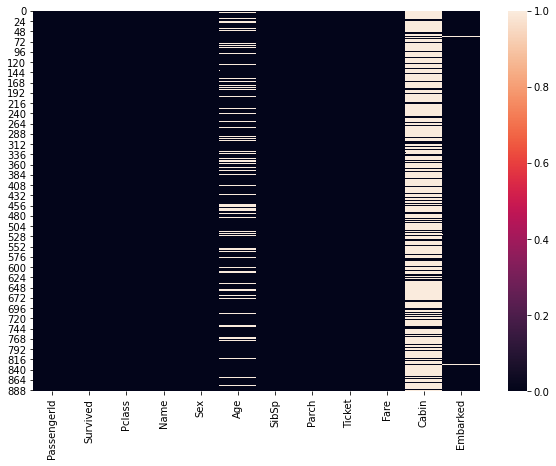

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(data=df.isna())

In [10]:
(df.isna().sum()/df.shape[0]).sort_values()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Embarked       0.002245
Age            0.198653
Cabin          0.771044
dtype: float64

# Analyse du fond

# Elimination des variables inutiles

In [11]:
df.drop(['PassengerId','Cabin','Name','Ticket'],axis=1,inplace=True)


In [12]:
df.dropna(axis=0, subset=['Embarked'],inplace=True)

In [13]:
df.shape

(889, 8)

In [14]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


# Visualisation de la target

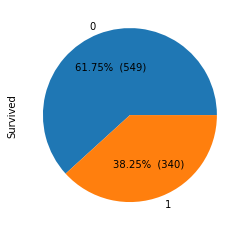

In [15]:
df['Survived'].value_counts().plot.pie(autopct=make_autopct(df['Survived'].value_counts()))

# Histogramme variable continue

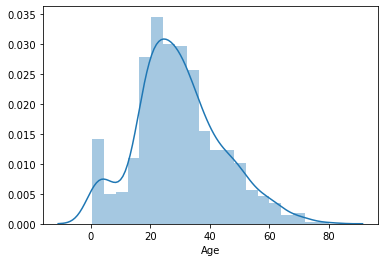

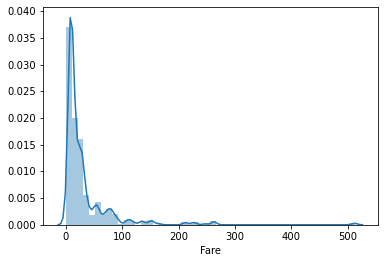

In [16]:
for col in df.select_dtypes('float64'):
    plt.figure()
    sns.distplot(df[col])

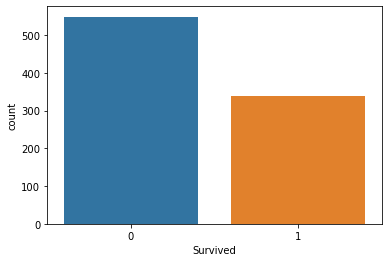

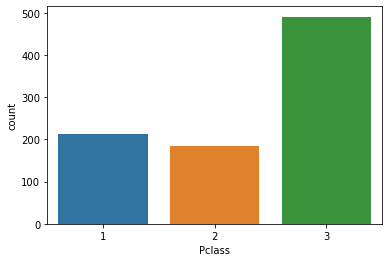

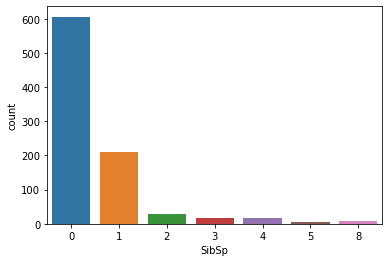

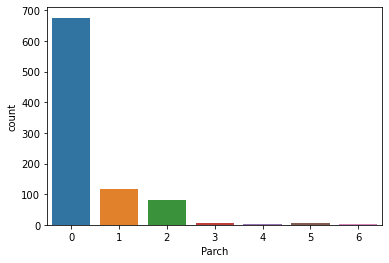

In [17]:
for col in df.select_dtypes('int64'):
    plt.figure()
    sns.countplot(df[col])

# Histogramme variable qualitative

In [18]:
for col in df.select_dtypes('object'):
    print(f'{col:-<30} {df[col].unique()}')

Sex--------------------------- ['male' 'female']
Embarked---------------------- ['S' 'C' 'Q']


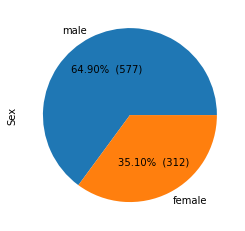

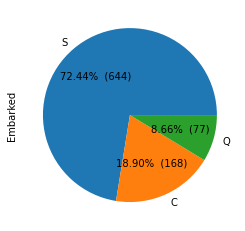

In [19]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie(autopct=make_autopct(df[col].value_counts()))

# Création des sous-ensembles Vivant/dead

In [20]:
df_vivant=df[df['Survived']==1]
df_dead=df[df['Survived']==0]

# Création de la catégorie 'a de la famille'

In [21]:
fam_col=['SibSp','Parch']

In [22]:
df['famille']=np.sum(df[fam_col],axis=1)>=1

In [23]:
df['famille'].value_counts(normalize=True)

False    0.6018
True     0.3982
Name: famille, dtype: float64

# Création d'une variable who

In [24]:
def who(df):
    if df['Age']<16.0:
        return 'child'
    elif df['Sex']=='male':
        return 'male'
    elif df['Sex']=='female':
        return 'female'

In [25]:
df['who']=df.apply(who,axis=1)

In [26]:
df['who'].value_counts()

male      537
female    269
child      83
Name: who, dtype: int64

In [27]:
pd.crosstab(df['who'],df['famille'])

famille,False,True
who,,
child,6,77
female,119,150
male,410,127


# Targe/age

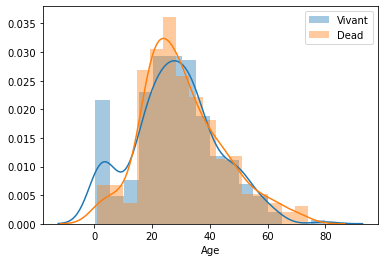

In [28]:
plt.figure()
sns.distplot(df_vivant['Age'],label='Vivant')
sns.distplot(df_dead['Age'],label='Dead')
plt.legend()

# Target/ Pclass et Target/Prix

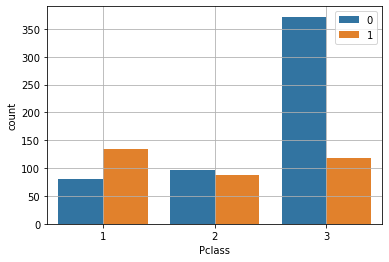

In [29]:
plt.figure()
sns.countplot(data=df,x='Pclass',hue='Survived')
plt.legend()
plt.grid()

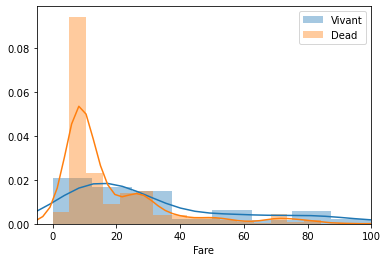

In [30]:
plt.figure()
sns.distplot(df_vivant['Fare'],label='Vivant')
sns.distplot(df_dead['Fare'],label='Dead')
plt.xlim(-5,100)
plt.legend()

# Target/who

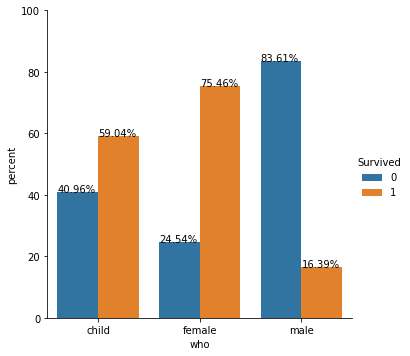

In [31]:
countplot_with_percent('who','Survived')

In [32]:
# df=titanic_data.copy()
# df.drop(['PassengerId','Cabin','Name','Ticket'],axis=1,inplace=True)
# df.dropna(axis=0, subset=['Embarked'],inplace=True)
# df['who']=df.apply(who,axis=1)
# df.head()

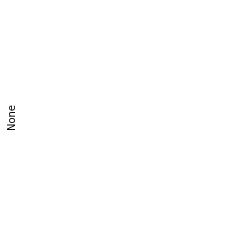

In [33]:
df[df['who']=='Child'].loc[:,['Sex','who']].value_counts().plot.pie(autopct=make_autopct(df[df['who']=='Child'].loc[:,['Sex','who']].value_counts()))

# Target/Sex

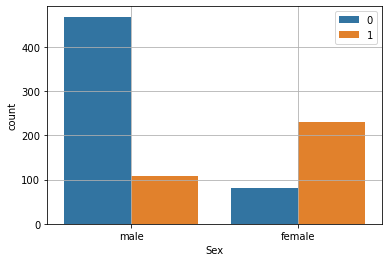

In [34]:
plt.figure()
sns.countplot(data=df,x='Sex',hue='Survived')
plt.legend()
plt.grid()

# Target/Embarked

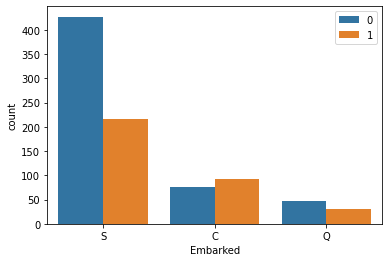

In [35]:
plt.figure()
sns.countplot(data=df,x='Embarked',hue='Survived')
plt.legend()
# plt.grid()

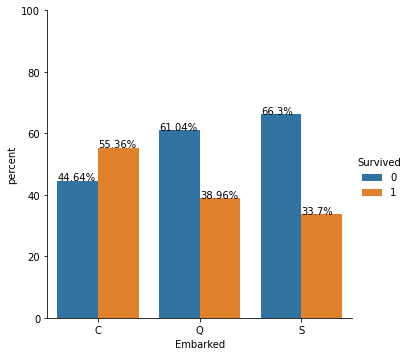

In [36]:
countplot_with_percent('Embarked','Survived')

# Target/famille

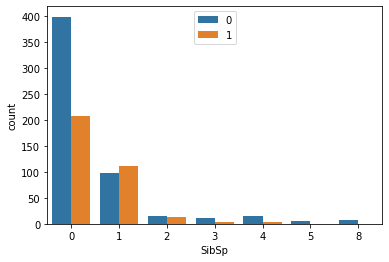

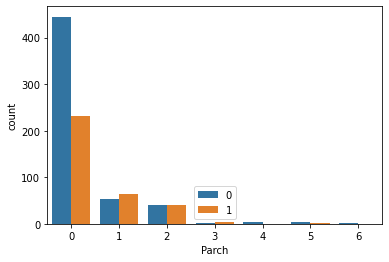

In [37]:
for col in fam_col:
    plt.figure()
    sns.countplot(data=df,x=col,hue='Survived')
#     plt.xlim(0,8)
    
    plt.legend()

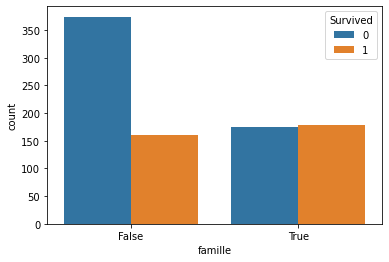

In [38]:
plt.figure()
sns.countplot(data=df,x='famille',hue='Survived')

# Analyse détaillée

# Relation Variables/variables

# famille/famille

In [39]:
df[fam_col].corr()

,SibSp,Parch
SibSp,1.000000,0.414542
Parch,0.414542,1.000000


# who/pclass

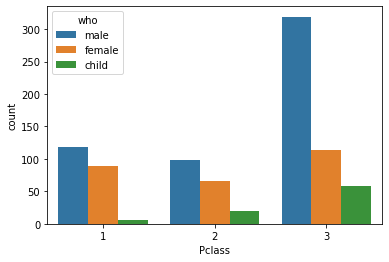

In [40]:
sns.countplot(x='Pclass',hue='who',data=df)

# age/fare

(-5.0, 300.0)

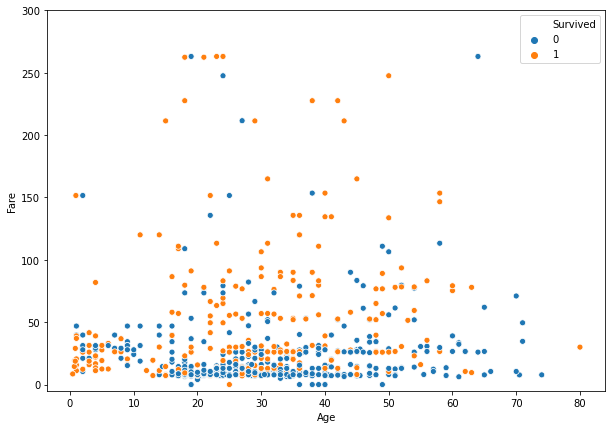

In [41]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=df.Age,y=df.Fare,hue=df.Survived)
# plt.xlim(10,50)
plt.ylim(-5,300)

(-5.0, 50.0)

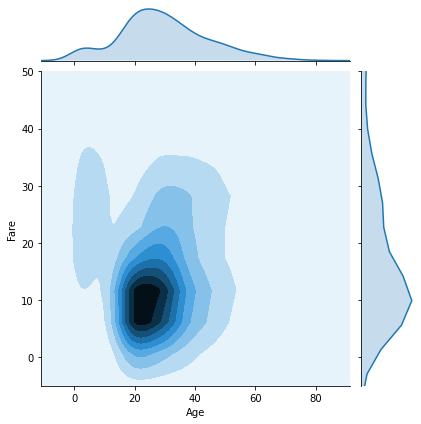

In [42]:
sns.jointplot(x=df.Age,y=df.Fare, kind='kde')
plt.ylim(-5,50)

# Embarked/who

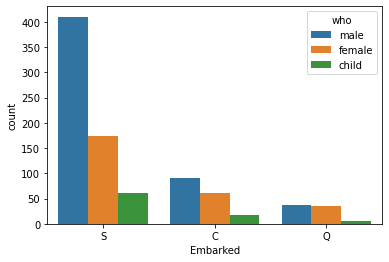

In [43]:
sns.countplot(data=df,x='Embarked',hue='who')

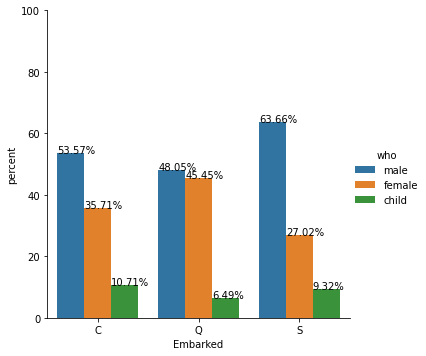

In [44]:
countplot_with_percent('Embarked', 'who')

# Embarked/pclass

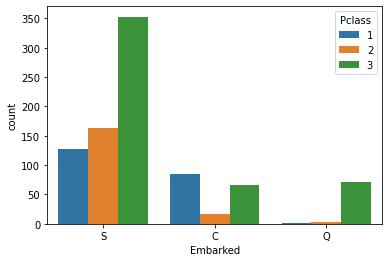

In [45]:
sns.countplot(data=df,x=df.Embarked,hue=df.Pclass)

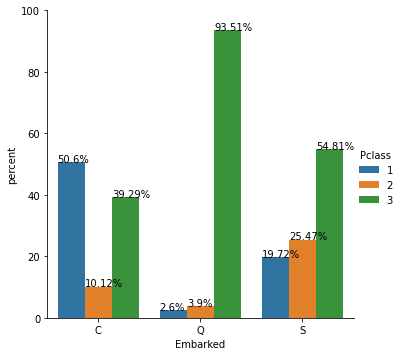

In [46]:
countplot_with_percent('Embarked', 'Pclass')

# Embarked/famille

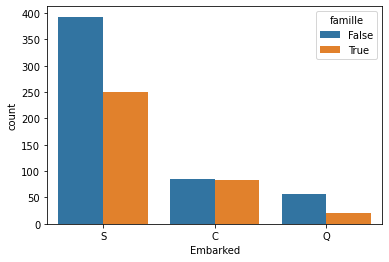

In [47]:
sns.countplot(data=df,x='Embarked',hue='famille')

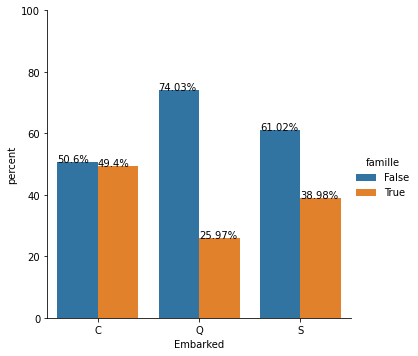

In [48]:
countplot_with_percent('Embarked', 'famille')

# Prepocessing

# Elimination des varibales/lignes inutiles

In [49]:
df=titanic_data.copy()

In [50]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [51]:
df.shape

(891, 12)

In [52]:
df.drop(['PassengerId','Cabin','Name','Ticket'],axis=1,inplace=True)
df.dropna(axis=0, subset=['Embarked'],inplace=True)

In [53]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [54]:
df.shape

(889, 8)

# Train/test - Nettoyage - Encodage

# train test split

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
trainset,testset=train_test_split(df,test_size=0.2,random_state=0)

In [57]:
trainset.Survived.value_counts(normalize=True)

0    0.624473
1    0.375527
Name: Survived, dtype: float64

In [58]:
testset.Survived.value_counts(normalize=True)

0    0.589888
1    0.410112
Name: Survived, dtype: float64

# Encodage

In [59]:
def encodage(df):
    code = {
            'male':0,
            'female':1,
            'child':2,
            'S':0,
            'C':1,
            'Q':2
           }
    for col in df.select_dtypes('object').columns:
        df.loc[:,col]=df[col].map(code)
    
    return df
        

# Imputation valeurs manquantes

In [60]:
def feature_engineering(df):
    df['who']=df.apply(who,axis=1)
    return df

In [61]:
def imputation(df):
#     df=df.dropna(axis=0)
    df=df.fillna(df.Age.mean())
    return df

In [62]:
def preprocessing(df):
    
    df=feature_engineering(df)
    
    df=encodage(df)
    
    df=imputation(df)
   
    
    X=df.drop('Survived',axis=1)
    y=df['Survived']
    
   
    print(y.value_counts())
    
    return X,y

In [63]:
X_train,y_train=preprocessing(trainset)

0    444
1    267
Name: Survived, dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [64]:
X_test,y_test=preprocessing(testset)

0    105
1     73
Name: Survived, dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Modélisation

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score,precision_score
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [66]:
model=RandomForestClassifier(random_state=0)

In [67]:
preprocessor=make_pipeline(SelectKBest(f_classif,k=8))

In [68]:
RandomForest=make_pipeline(preprocessor,RandomForestClassifier(random_state=0))
AdaBoost=make_pipeline(preprocessor,AdaBoostClassifier(random_state=0))
SVM=make_pipeline(preprocessor,StandardScaler(),SVC(random_state=0))
KNN=make_pipeline(preprocessor,StandardScaler(),KNeighborsClassifier())

In [69]:
models={'RandomForest':RandomForest,'AdaBoost':AdaBoost,'SVM':SVM,'KNN':KNN}

# Procédure d'évaluation

In [70]:
def evaluation(model):
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    print(accuracy_score(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred)) 
    print(classification_report(y_test,y_pred))
    
    N,train_score,val_score=learning_curve(model, X_train,y_train,cv=4,train_sizes=np.linspace(0.1,1,10),
                                          scoring='accuracy')
    
    plt.figure(figsize=(12,8))
    plt.plot(N,train_score.mean(axis=1),label='Train score')
    plt.plot(N,val_score.mean(axis=1), label='val_score')
    plt.legend()

In [71]:
# for name,model in models.items():
#     print(name)
#     evaluation(model)

In [72]:
# evaluation(model)

In [73]:
# pd.DataFrame(model.feature_importances_,index=X_train.columns).plot.bar(figsize=(12,6))

In [74]:
def eval_model1():
    
    for k in range (1,9):
        model1=make_pipeline(SelectKBest(f_classif,k=k),
                    RandomForestClassifier(random_state=0))
        print ('k = ',k)
        evaluation(model1)

In [75]:
# eval_model1() #resultat k=6 est le meilleur paramètre

In [76]:
# evaluation(model1)

# Optimisation

In [77]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_recall_curve

# SVM

In [78]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('selectkbest', SelectKBest(k=8))])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [79]:
SVM.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('selectkbest', SelectKBest(k=8))])),
  ('standardscaler', StandardScaler()),
  ('svc', SVC(random_state=0))],
 'verbose': False,
 'pipeline': Pipeline(steps=[('selectkbest', SelectKBest(k=8))]),
 'standardscaler': StandardScaler(),
 'svc': SVC(random_state=0),
 'pipeline__memory': None,
 'pipeline__steps': [('selectkbest', SelectKBest(k=8))],
 'pipeline__verbose': False,
 'pipeline__selectkbest': SelectKBest(k=8),
 'pipeline__selectkbest__k': 8,
 'pipeline__selectkbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'sv

In [80]:
def svmgridmodel():
    
    hyper_params={'svc__C': [1,10,100,1000],
                  'svc__gamma':[1e-2,1e-3,1e-4]
                 }
    grid=GridSearchCV(SVM,hyper_params,scoring='accuracy',cv=4)

    grid.fit(X_train,y_train)

    print(grid.best_params_)

    ypred=grid.predict(X_test)

#     print(classification_report(y_test,ypred))
    
    evaluation(grid.best_estimator_)

In [81]:
# svmgridmodel()

In [82]:
def svmrandmodel():
    
    hyper_params={'svc__C': [1,10,100,1000,3000],
                  'svc__gamma':[1e-2,1e-3,1e-4,0.0005],
                  'pipeline__selectkbest__k': range(4,9),
                  
                 }
    rand=RandomizedSearchCV(SVM,hyper_params,scoring='accuracy',cv=4,n_iter=40)

    rand.fit(X_train,y_train)

    print(rand.best_params_)

    ypred=rand.predict(X_test)

#     print(classification_report(y_test,ypred))
    
    evaluation(rand.best_estimator_)
    precision, recall , threshold=precision_recall_curve(y_test,rand.best_estimator_.decision_function(X_test))
    
    plt.figure()
    plt.plot(threshold,precision[:-1],label='precision')
    plt.plot(threshold,recall[:-1],label='recall')
#     plt.xlim(-5,1)
#     plt.ylim(0.2,1)
    plt.legend()
    plt.grid()

{'svc__gamma': 0.01, 'svc__C': 100, 'pipeline__selectkbest__k': 8}
0.7471910112359551
[[92 13]
 [32 41]]
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       105
           1       0.76      0.56      0.65        73

    accuracy                           0.75       178
   macro avg       0.75      0.72      0.72       178
weighted avg       0.75      0.75      0.74       178



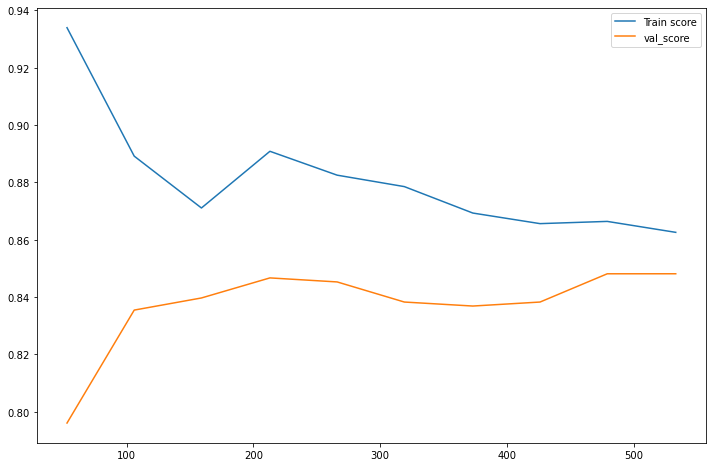

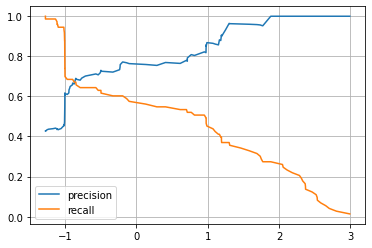

In [83]:
svmrandmodel()

In [84]:
# for i in range (len(y_pred)):
#     if y_pred[i]==True:
#         y_pred[i]=1
#     else:
#         y_pred[i]=0
# print(y_pred)

# AdaBoost

In [85]:
AdaBoost

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('selectkbest', SelectKBest(k=8))])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [86]:
AdaBoost.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('selectkbest', SelectKBest(k=8))])),
  ('adaboostclassifier', AdaBoostClassifier(random_state=0))],
 'verbose': False,
 'pipeline': Pipeline(steps=[('selectkbest', SelectKBest(k=8))]),
 'adaboostclassifier': AdaBoostClassifier(random_state=0),
 'pipeline__memory': None,
 'pipeline__steps': [('selectkbest', SelectKBest(k=8))],
 'pipeline__verbose': False,
 'pipeline__selectkbest': SelectKBest(k=8),
 'pipeline__selectkbest__k': 8,
 'pipeline__selectkbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'adaboostclassifier__algorithm': 'SAMME.R',
 'adaboostclassifier__base_estimator': None,
 'adaboostclassifier__learning_rate': 1.0,
 'adaboostclassifier__n_estimators': 50,
 'adaboostclassifier__random_state': 0}

In [87]:
def adagridmodel():
    
    hyper_params={'adaboostclassifier__n_estimators': [50,100,150],
                  'adaboostclassifier__learning_rate': [1,1e-1,1e-2]
                 }
    grid=GridSearchCV(AdaBoost,hyper_params,scoring='accuracy',cv=4)

    grid.fit(X_train,y_train)

    print(grid.best_params_)

    ypred=grid.predict(X_test)

#     print(classification_report(y_test,ypred))
    
    evaluation(grid.best_estimator_)
    precision, recall , threshold=precision_recall_curve(y_test,grid.best_estimator_.decision_function(X_test))
    
    plt.figure()
    plt.plot(threshold,precision[:-1],label='precision')
    plt.plot(threshold,recall[:-1],label='recall')
#     plt.xlim(-5,1)
#     plt.ylim(0.2,1)
    plt.legend()

{'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 50}
0.6966292134831461
[[79 26]
 [28 45]]
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       105
           1       0.63      0.62      0.63        73

    accuracy                           0.70       178
   macro avg       0.69      0.68      0.69       178
weighted avg       0.70      0.70      0.70       178



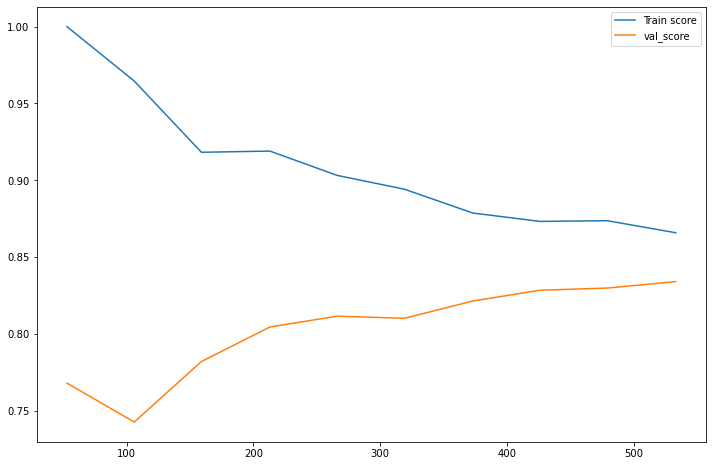

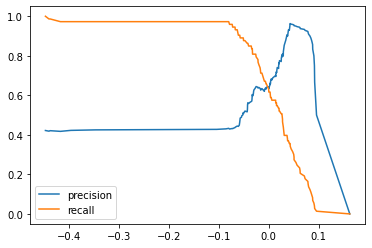

In [88]:
adagridmodel()

In [89]:
df1=test_data.copy()

In [90]:
df1.drop(['PassengerId','Cabin','Name','Ticket'],axis=1,inplace=True)
df1['who']=df1.apply(who,axis=1)

In [91]:
df1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,who
0,3,male,34.5,0,0,7.8292,Q,male
1,3,female,47.0,1,0,7.0000,S,female
2,2,male,62.0,0,0,9.6875,Q,male
3,3,male,27.0,0,0,8.6625,S,male
4,3,female,22.0,1,1,12.2875,S,female


In [92]:
def final_preprocessing(df):
    
#     df=feature_engineering(df)
    
    df=encodage(df)
    
    df['Age']=df['Age'].fillna(df.Age.mean())
    df['Fare']=df['Fare'].fillna(df.Fare.mean())
#     print (df.isna().sum())
   
    
    X=df
    
    
   
    
    
    return X

In [93]:
final_preprocessing(df1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,who
0,3,0,34.50000,0,0,7.8292,2,0
1,3,1,47.00000,1,0,7.0000,0,1
2,2,0,62.00000,0,0,9.6875,2,0
3,3,0,27.00000,0,0,8.6625,0,0
4,3,1,22.00000,1,1,12.2875,0,1
...,...,...,...,...,...,...,...,...
413,3,0,30.27259,0,0,8.0500,0,0
414,1,1,39.00000,0,0,108.9000,1,1
415,3,0,38.50000,0,0,7.2500,0,0
416,3,0,30.27259,0,0,8.0500,0,0


In [94]:
SVM_best=SVM=make_pipeline(preprocessor,StandardScaler(),SVC(C=10000,gamma=0.0001,random_state=0))

In [95]:
SVM_best.fit(X_train,y_train)
AdaBoost.fit(X_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('selectkbest', SelectKBest(k=8))])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [96]:
def evaluationfinal(df,model):
    
    X=final_preprocessing(df1)
    y_pred=model.predict(X)
    
    return y_pred

In [97]:
def model_final(model,X,threshold=0):
    return model.decision_function(X)>threshold

In [98]:
Xfinal=final_preprocessing(df1)
y_pred=model_final(SVM_best,Xfinal,threshold=-0.8)
y_pred=y_pred.reshape(418,1)


In [99]:
# y=evaluationfinal(df1,RandomForest)
y1=evaluationfinal(df1,SVM_best)
y1bis=y_pred.sum(axis=1)
y2=y1=evaluationfinal(df1,AdaBoost)

In [100]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': y1})
output.to_csv('submission.csv', index=False)